<a href="https://colab.research.google.com/github/iyappan24/Applied-AI-Notebooks/blob/master/TSNE_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AMAZON FINE FOOD REVIEWS : T-SNE ASSIGNMENT**

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

In [0]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
import nltk
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import random
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import sqlite3

----------------

Mounting google drive to get the data from the google drive folder
-------------


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
con = sqlite3.connect('/content/gdrive/My Drive/AppliedAI/Amazon Fine Food Reviews/database.sqlite')

In [0]:
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [16]:
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [0]:
def partition(x):
    if x < 3:
        return 0
    return 1

In [0]:
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [19]:
filtered_data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [20]:
print("Number of data points in our data", filtered_data.shape)

Number of data points in our data (525814, 10)


In [21]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [23]:
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

**Amount of data that is remaining after dropping the duplicates and filtering **

In [24]:
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

## TEXT PRE-PROCESSING

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

** REMOVING HTML TAGS ** 

In [0]:
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [0]:
stop = set(stopwords.words('english'))
sno = nltk.stem.SnowballStemmer('english')

In [0]:
#removing not and no from list of stopwords 
stop.remove('not')
stop.remove('no')

In [0]:
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1
        
#############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()

In [0]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()

In [39]:
final.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...


In [40]:
final.shape

(364173, 12)

** GETTING RANDOM POINTS N-K FROM POSTIVE REVIEWS AND NEGATIVE REVIEWS **

In [0]:
def r_sampling(n):
    if n >10000:
        return "cannot sample more than 10k"
    else:
        p_index = list(final[final['Score']==1].index)
        p_final = []
        for i in random.sample(range(0,len(final[final['Score']==1])),n):
            p_final.append(p_index[i])
        
        n_index =  list(final[final['Score']==0].index)
        n_final = []
        for i in random.sample(range(0,len(final[final['Score']==0])),n):
            n_final.append(n_index[i])
        
        return pd.concat([final.iloc[p_final],final.iloc[n_final]],axis = 0,ignore_index=True)

In [0]:
df = r_sampling(4000)

In [43]:
pd.value_counts(df['Score'])

1    4000
0    4000
Name: Score, dtype: int64

------------
## WORD2VEC

In [0]:
#creating the word splits for each sentence
i =0 
list_of_sent = []
for sent in df['CleanedText'].values:
    list_of_sent.append(sent.split())

In [0]:
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

Computing Word2Vec for each review or sentence: ** Average Word to Vec ** 

In [46]:
sent_vectors = []
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_model:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

100%|██████████| 8000/8000 [00:02<00:00, 2928.30it/s]


In [0]:
df.drop('index',axis =1 ,inplace= True)

In [0]:
c= []
for i in range(0,50):
    c.append("Vector " + str(i+1))

In [0]:
w2v = pd.DataFrame(sent_vectors,columns=c)

In [0]:
w2v['Score'] = df['Score']

In [52]:
w2v.head()

,Vector 1,Vector 2,Vector 3,Vector 4,Vector 5,Vector 6,Vector 7,Vector 8,Vector 9,Vector 10,...,Vector 42,Vector 43,Vector 44,Vector 45,Vector 46,Vector 47,Vector 48,Vector 49,Vector 50,Score
0,-0.372128,0.884527,-0.249485,-0.287798,-0.033781,-0.322109,-0.568060,0.226907,-0.167685,-0.090740,...,-0.578905,0.720385,-0.726836,-0.471056,-0.422020,0.027732,-0.128004,0.008141,-0.054673,1
1,-0.281544,0.799874,-0.191336,-0.090080,-0.120555,-0.110908,-0.448809,0.128144,-0.071958,-0.035226,...,-0.353160,0.944775,-0.755344,-0.681172,-0.251415,0.101774,-0.267857,-0.202463,-0.170199,1
2,-0.283137,0.529086,-0.109919,-0.042073,0.102747,-0.186906,-0.536661,0.237688,-0.028907,-0.023187,...,-0.112547,0.424219,-0.413336,-0.550377,-0.438738,-0.108822,-0.048030,-0.189035,0.065243,1
3,-0.421195,0.827715,-0.215561,-0.166664,0.250585,-0.325612,-0.715663,0.386233,-0.057173,-0.151987,...,-0.297070,0.421682,-0.495089,-0.566349,-0.616512,-0.151657,0.030401,-0.121383,0.140307,1
4,-0.509209,0.925718,-0.284001,-0.125492,0.193971,-0.195734,-0.635081,0.252043,0.054707,-0.153303,...,-0.288517,0.554230,-0.633025,-0.486882,-0.440596,-0.013578,-0.132415,-0.123106,0.020519,1


In [0]:
y = w2v['Score']
x = w2v.loc[:,:'Vector 50']

-----
** APPLYIN T-SNE TO WORD2VEC ** 

In [0]:
sc = StandardScaler()
std_data = sc.fit_transform(x)

In [0]:
tsne = TSNE(n_components=2,perplexity=5,n_iter=2000,learning_rate=100)

In [0]:
t_data= tsne.fit_transform(std_data)

In [0]:
tsne_data = np.vstack((t_data.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

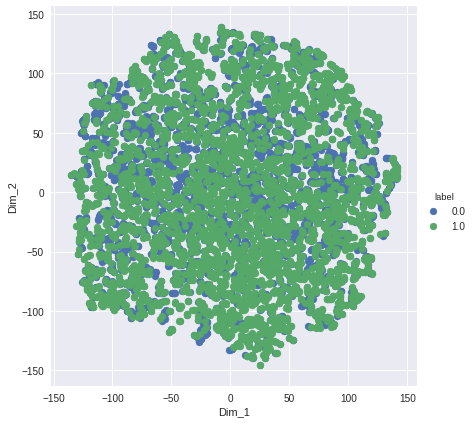

In [58]:
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

-------------------------------------
## BAG OF WORDS

In [59]:
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(df['CleanedText'].values)
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

the shape of out text BOW vectorizer  (8000, 11852)
the number of unique words  11852


In [0]:
bow = pd.DataFrame(final_counts.todense(),columns=count_vect.get_feature_names())

In [0]:
bow['Score'] = df['Score']

In [63]:
bow.head()

,aaaaa,aaah,aafco,ab,abandon,abbott,abc,abdomin,abenefici,abhorr,...,ziwipeak,zoe,zoji,zola,zone,zotz,zout,zucchini,zuke,Score
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [64]:
bow.columns

Index(['aaaaa', 'aaah', 'aafco', 'ab', 'abandon', 'abbott', 'abc', 'abdomin',
       'abenefici', 'abhorr',
       ...
       'ziwipeak', 'zoe', 'zoji', 'zola', 'zone', 'zotz', 'zout', 'zucchini',
       'zuke', 'Score'],
      dtype='object', length=11853)

In [0]:
y = bow['Score']
x = bow.loc[:,:'zuke']

In [0]:
sc = StandardScaler()
std_data = sc.fit_transform(x)
tsne = TSNE(n_components=2,perplexity=5,n_iter=2000,learning_rate=100)

In [0]:
t_data= tsne.fit_transform(std_data)

In [0]:
tsne_data = np.vstack((t_data.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

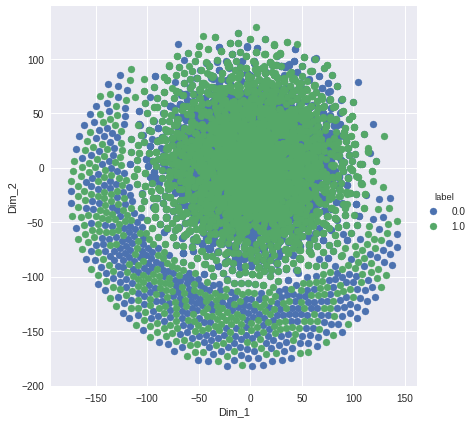

In [71]:
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

-----------
## TF-IDF WORD2VEC

In [0]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final['CleanedText'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [76]:
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_model:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 8000/8000 [00:04<00:00, 1679.49it/s]


In [0]:
c= []
for i in range(0,50):
    c.append("Vector " + str(i+1))
tfidfw2v = pd.DataFrame(tfidf_sent_vectors,columns=c)

In [0]:
tfidfw2v['Score']= df['Score']

In [0]:
y = w2v['Score']
x = w2v.loc[:,:'Vector 50']
sc = StandardScaler()
std_data = sc.fit_transform(x)
tsne = TSNE(n_components=2,perplexity=5,n_iter=2000,learning_rate=200)

In [0]:
t_data= tsne.fit_transform(std_data)

In [0]:
tsne_data = np.vstack((t_data.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

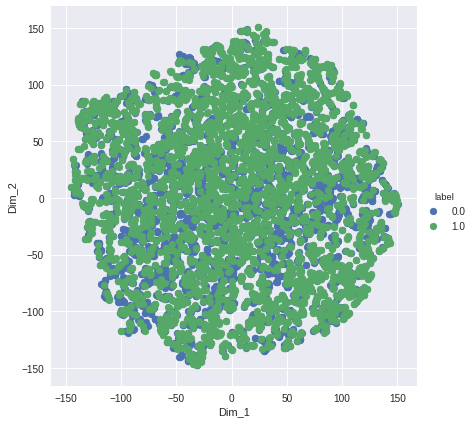

In [90]:
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

-------------------------------------------------
## TF-IDF : Only Bi-Grams

In [0]:
df = r_sampling(1000)

In [0]:
tf_idf_vect = TfidfVectorizer(lowercase=True,ngram_range=(2,2))
ftf_idf = tf_idf_vect.fit_transform(df['CleanedText'].values)

In [7]:
print("the shape of out text TFIDF vectorizer ",ftf_idf.get_shape())
print("the number of unique bigrams ", ftf_idf.get_shape()[1])

the shape of out text TFIDF vectorizer  (2000, 59513)
the number of unique bigrams  59513


In [0]:
ftfidf = pd.DataFrame(ftf_idf.toarray(),columns=tf_idf_vect.get_feature_names())

In [0]:
ftfidf['Score'] = df['Score']

In [16]:
ftfidf.columns

Index(['abc news', 'abc six', 'abdomin cramp', 'abdomin distress',
       'aberr limit', 'abil feel', 'abl afford', 'abl around', 'abl brew',
       'abl bring',
       ...
       'zotz orang', 'zuke bound', 'zuke chicken', 'zuke futur',
       'zuke household', 'zuke mini', 'zuke soon', 'zuke though',
       'zylitol look', 'Score'],
      dtype='object', length=59514)

In [0]:
y = ftfidf['Score']
x = ftfidf.loc[:,:'zylitol look']
sc = StandardScaler()
std_data = sc.fit_transform(x)
tsne = TSNE(n_components=2,perplexity=10,n_iter=1000,learning_rate=250)

In [0]:
t_data= tsne.fit_transform(std_data)

In [0]:
tsne_data = np.vstack((t_data.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

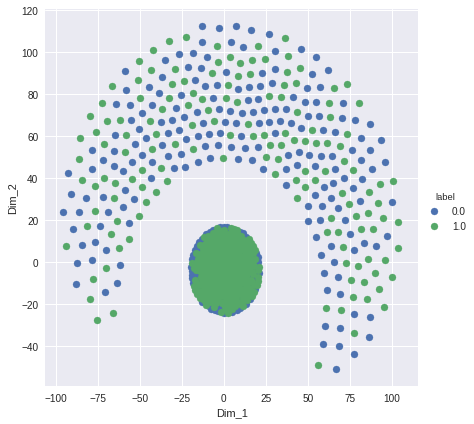

In [15]:
sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()